In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('heart_disease_uci.csv')

# Data cleaning and preprocessing
# Handle missing values (for simplicity, we'll drop rows with missing values in key columns)
df = df.dropna(subset=['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'thalch', 'exang', 'oldpeak', 'num'])

# Convert target to binary (0 = no heart disease, 1-4 = heart disease)
df['target'] = df['num'].apply(lambda x: 0 if x == 0 else 1)

# Select relevant features
features = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'thalch', 'exang', 'oldpeak']
X = df[features]
y = df['target']

# Convert categorical variables to numerical
le = LabelEncoder()
X['sex'] = le.fit_transform(X['sex'])
X['cp'] = le.fit_transform(X['cp'])
X['fbs'] = le.fit_transform(X['fbs'])
X['exang'] = le.fit_transform(X['exang'])

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

<ipython-input-1-e0d85b47e5c2>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['sex'] = le.fit_transform(X['sex'])
<ipython-input-1-e0d85b47e5c2>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['cp'] = le.fit_transform(X['cp'])
<ipython-input-1-e0d85b47e5c2>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

In [2]:
# Initialize KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)

# Train the model
knn.fit(X_train, y_train)

# Make predictions
y_pred = knn.predict(X_test)

Accuracy: 0.75

Confusion Matrix:
[[85 29]
 [26 83]]

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.75      0.76       114
           1       0.74      0.76      0.75       109

    accuracy                           0.75       223
   macro avg       0.75      0.75      0.75       223
weighted avg       0.75      0.75      0.75       223



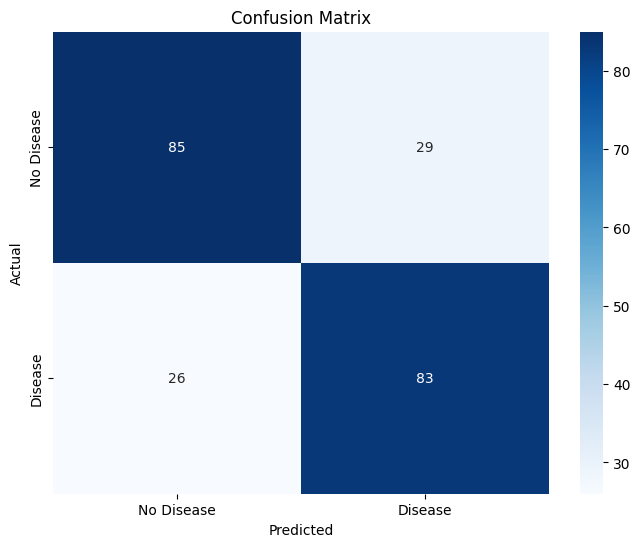

In [3]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

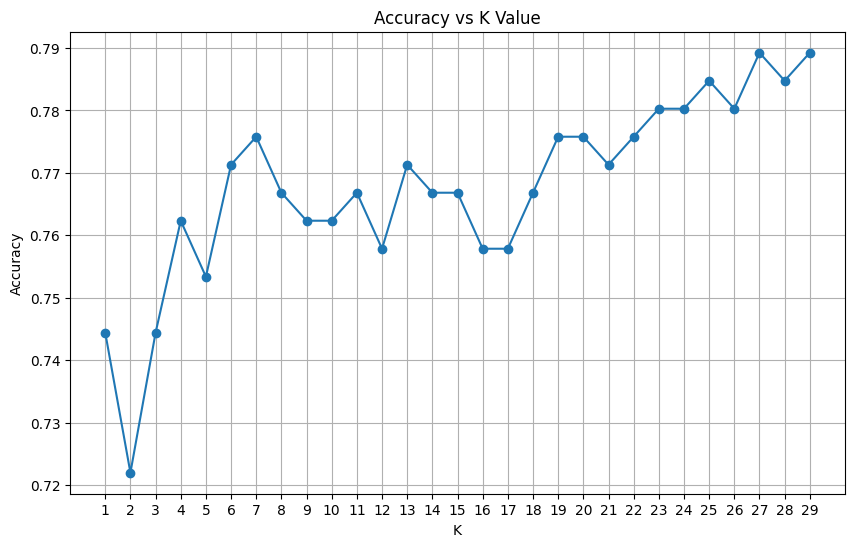

Optimal K value: 27


In [4]:
# Test different K values
k_values = range(1, 30)
accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))

# Plot accuracy vs K
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o')
plt.title('Accuracy vs K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.xticks(k_values)
plt.grid()
plt.show()

# Find optimal K
optimal_k = k_values[np.argmax(accuracies)]
print(f"Optimal K value: {optimal_k}")

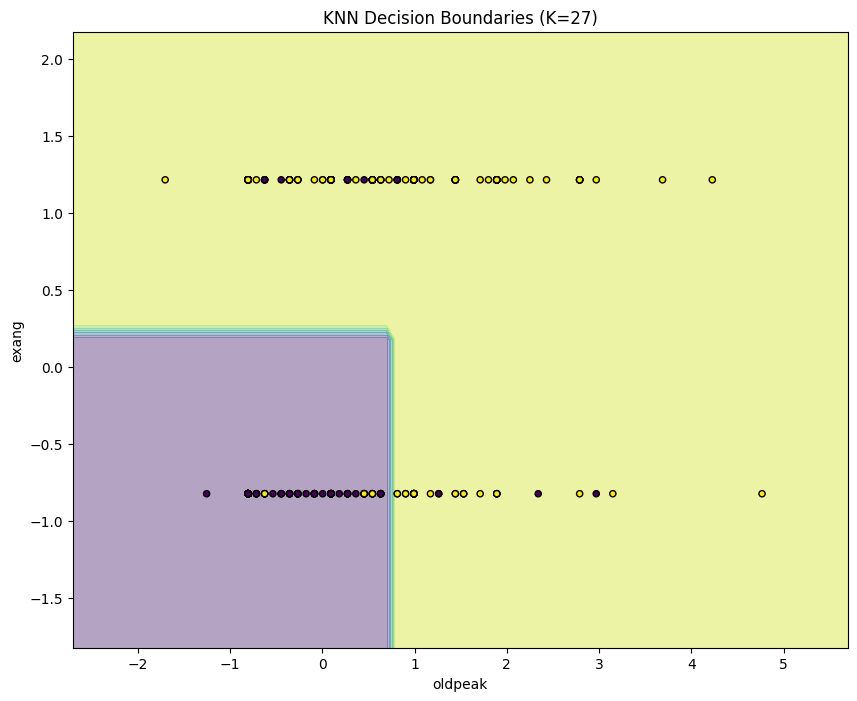

In [5]:
# Get feature importances (using a simple method)
from sklearn.inspection import permutation_importance

knn_final = KNeighborsClassifier(n_neighbors=optimal_k)
knn_final.fit(X_train, y_train)

result = permutation_importance(knn_final, X_train, y_train, n_repeats=10, random_state=42)
important_features = np.argsort(result.importances_mean)[-2:]  # Get top 2 features

# Create 2D visualization
X_2d = X_train[:, important_features]

# Train KNN on these 2 features
knn_2d = KNeighborsClassifier(n_neighbors=optimal_k)
knn_2d.fit(X_2d, y_train)

# Create mesh grid
x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Predict for each point in mesh grid
Z = knn_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_train, s=20, edgecolor='k')
plt.title(f'KNN Decision Boundaries (K={optimal_k})')
plt.xlabel(features[important_features[0]])
plt.ylabel(features[important_features[1]])
plt.show()